In [1]:
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.express as px
import wandb
from sklearn.model_selection import train_test_split
import cv2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from torchinfo import summary

from src.utils import EarlyStopper

In [7]:
a = torch.zeros((1, 3, 64, 64))
nn.Conv2d(3, 3, kernel_size=3, stride=2, padding=1)(a).shape

torch.Size([1, 3, 32, 32])

# American Sign Language classification

In [2]:
config = {
    "lr": 1e-2, # 1e-3
    "dataset": "ASL",
    "epochs": 20,
    "batch_size": 256,
    "image_shape": (64, 64, 3),
    "classes": 29,
    "activations": "ReLU",
    "conv_layers": 4,
    "loss": "cross-entropy",
    "optimizer": "Adam",
    "augment": False,
    "scheduler": True,
    "earlyStoppingValue": "loss" # loss/accuracy
}

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [4]:
use_wandb = False
if use_wandb:
    wandb.login()
    wandb.init(project='pvid-assignment-4', name='', entity='kuko', reinit=True, config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kuko (ns-super-team). Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: kuko. Use `wandb login --relogin` to force relogin


## Data

In [5]:
# data_dir = 'data/asl_alphabet_train/'
# data_dir = 'data/Train_Alphabet/'
# data_dir = 'data/asl_dataset/'
data_dir = 'data/MezclaDatasets/'
# data_dir = 'data/ASL_Alphabet_Dataset/asl_alphabet_train/'

# data = glob.glob('*/*.jpg', root_dir=data_dir)
# data = glob.glob('*/*.png', root_dir=data_dir)
data = glob.glob('*/*.[jp][pn]g', root_dir=data_dir)
print(len(data))
print(data[:5])

90162
['R/63.jpg', 'R/R2837.jpg', 'R/R2189.jpg', 'R/R1480.jpg', 'R/189.jpg']


In [6]:
labels = sorted(glob.glob('*', root_dir=data_dir))
print(len(labels))
print(labels)

29
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [7]:
for label in labels:
    print(label, len(os.listdir(os.path.join(data_dir, label))))

A 3632
B 3649
C 3548
D 3482
E 3683
F 3534
G 3460
H 3465
I 3464
J 1800
K 3423
L 3448
M 3378
N 3390
O 3489
P 3337
Q 3374
R 3386
S 3396
T 3387
U 3373
V 3424
W 3431
X 3391
Y 3406
Z 1800
del 1800
nothing 1800
space 1800


In [8]:
labels_map = dict()
reversed_labels_map = dict()

for i, label in enumerate(labels):
    labels_map[i] = label
    reversed_labels_map[label] = i

print(labels_map)
print(reversed_labels_map)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [9]:
import json

with open('data/labels.json', 'w') as fp:
    json.dump(labels_map, fp)

In [10]:
class SignDataset(Dataset):
    def __init__(self, imgs, data_dir, labels_map, transform=None, augment=False):
        self.labels_map = labels_map
        self.imgs = imgs
        self.data_dir = data_dir
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.imgs)
    
    def __augment(self, image):
        if random.random() > 0.4:
            angle = random.randint(-10, 10)
            image = TF.rotate(image, angle)
            
        return image

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.imgs[idx])
        image = read_image(img_path, ImageReadMode.RGB).float()
        image = image / 255.0
        label = self.labels_map[self.imgs[idx].split('/')[0]]

        if self.transform:
            image = self.transform(image)
        
        if self.augment:
            image = self.__augment(image)
        
        return image, label

In [11]:
data_train, data_val = train_test_split(data, test_size=0.2, train_size=0.8, random_state=420)
print(f'train: {len(data_train)}, val: {len(data_val)} | {len(data_train)+len(data_val)}')

train: 72129, val: 18033 | 90162


In [12]:
transform = transforms.Compose([transforms.Resize(config['image_shape'][0]+4, antialias=False), transforms.CenterCrop(config['image_shape'][0])])

train_data = SignDataset(data_train, data_dir, reversed_labels_map, transform=transform, augment=config['augment'])
val_data = SignDataset(data_val, data_dir, reversed_labels_map, transform=transform, augment=False)

In [13]:
train_dataloader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=False)

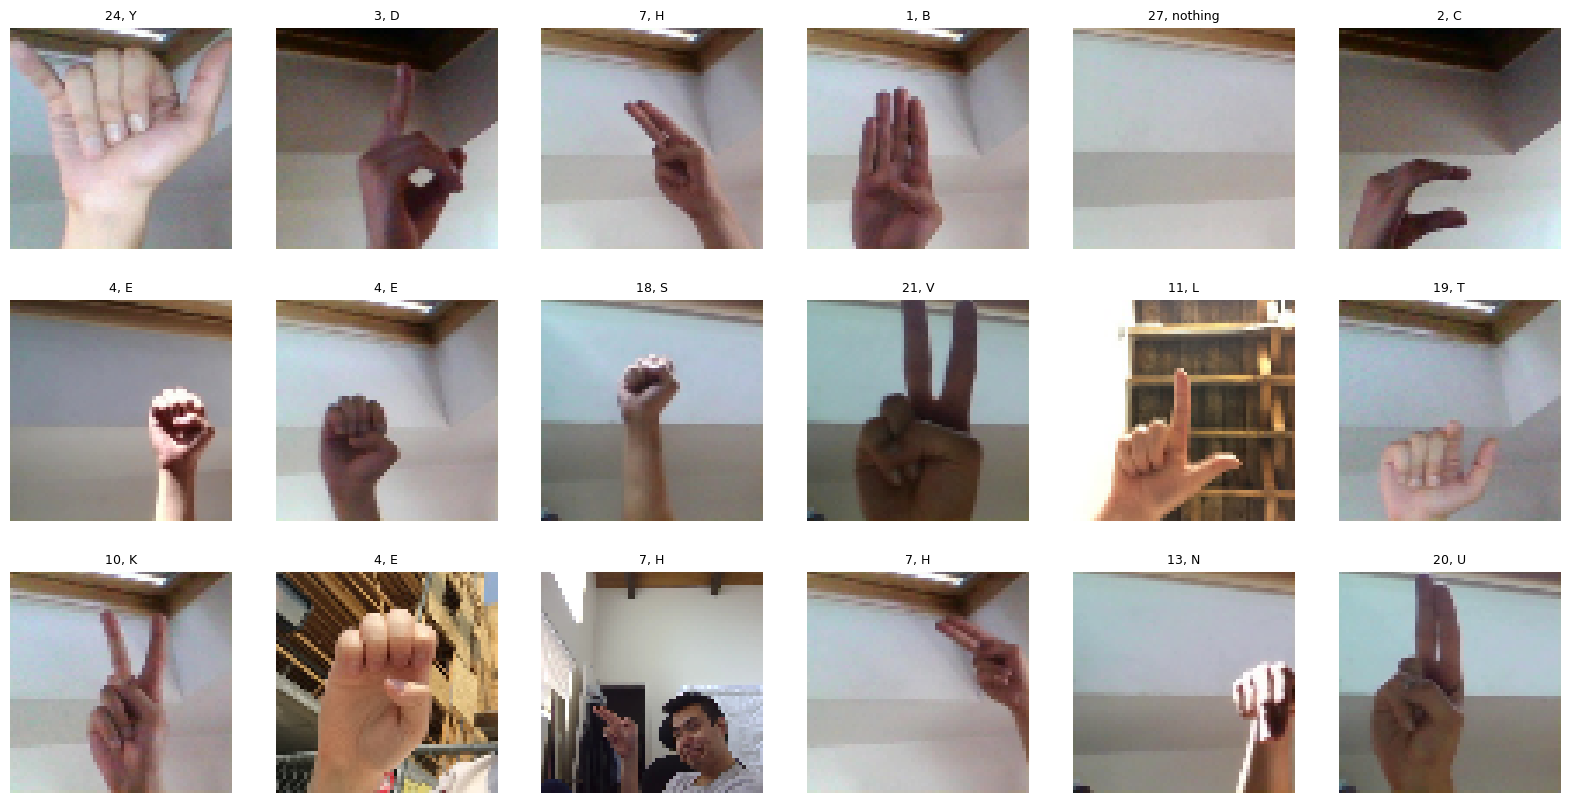

In [14]:
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
axs = axs.flatten()

images, labels = next(iter(val_dataloader))
for i, (img, label) in enumerate(zip(images, labels)):
    if i == 18: break
    axs[i].imshow(img[:,:,:].permute(1, 2, 0))
    axs[i].set_title(f'{label.item()}, {labels_map[label.item()]}', fontsize=9)
    axs[i].axis('off')
plt.show()

## Model

In [47]:
from torch import nn

def build_conv_block(in_channels, out_channels, double=False):
    layers = [
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    ]

    # add another convolution
    if double:
        layers.extend([
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ])

    # add downsampling
    layers.extend([
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
        #nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        # nn.Dropout2d(p=0.3)
    ])

    return nn.Sequential(*layers)

class Model(nn.Module):
    def __init__(self, in_channels=3, channels=[32, 64, 128, 256], blocks=4, double=False):
        super().__init__()
        self.features = nn.Sequential()

        for i in range(blocks):
            if i == (blocks-1):
                self.features.add_module(f'block{i}', build_conv_block(in_channels, channels[i], double=double))    
            else:
                self.features.add_module(f'block{i}', build_conv_block(in_channels, channels[i]))
            in_channels = channels[i]
        
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(in_channels*4*4, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, config['classes']),
        )

    def forward(self, x):
        out = self.features(x)
        out = self.flatten(out)
        out = self.fc(out)
        
        return out   

In [48]:
Model()

Model(
  (features): Sequential(
    (block0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (block1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (block3): Sequential(

In [49]:
summary(Model(), (256, 3, 64, 64))

/Users/kuko/miniconda3/envs/cv/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/Users/kuko/miniconda3/envs/cv/lib/python3.10/site-packages/torch/storage.py:665: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [256, 29]                 --
├─Sequential: 1-1                        [256, 256, 4, 4]          --
│    └─Sequential: 2-1                   [256, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [256, 32, 64, 64]         896
│    │    └─BatchNorm2d: 3-2             [256, 32, 64, 64]         64
│    │    └─ReLU: 3-3                    [256, 32, 64, 64]         --
│    │    └─Conv2d: 3-4                  [256, 32, 32, 32]         9,248
│    │    └─ReLU: 3-5                    [256, 32, 32, 32]         --
│    └─Sequential: 2-2                   [256, 64, 16, 16]         --
│    │    └─Conv2d: 3-6                  [256, 64, 32, 32]         18,496
│    │    └─BatchNorm2d: 3-7             [256, 64, 32, 32]         128
│    │    └─ReLU: 3-8                    [256, 64, 32, 32]         --
│    │    └─Conv2d: 3-9                  [256, 64, 16, 16]         36,928
│ 

## Training

In [18]:
def preview(model: Model, dataloader: DataLoader, filename, save=False, use_wandb=False, step=None):
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(3, 6, figsize=(20, 13))
        axs = axs.flatten()
        
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)
        
        y_pred = model(images)
        y_pred_labels = torch.argmax(y_pred, dim=1) 
        for i, (img, label) in enumerate(zip(images, labels)):
            if i == 18: break

            original = f'Original: {label.item()}, {labels_map[label.item()]}'
            predicted = f'Predicted: {y_pred_labels[i].item()}, {labels_map[y_pred_labels[i].item()]}'
            
            title_color = 'black' if labels[i].item() == y_pred_labels[i].item() else 'red' 
            axs[i].imshow(img[:,:,:].cpu().permute(1, 2, 0))
            axs[i].set_title(original+'\n'+predicted, fontsize=9, color=title_color)
            axs[i].axis('off')
            # plt.show()
         
        if save:
            fig.savefig(f'outputs/{filename}_preview.png')
            plt.close(fig)
        
    if use_wandb:
        wandb.log({'preview': wandb.Image(f'outputs/{filename}_preview.png')}, step=step)  

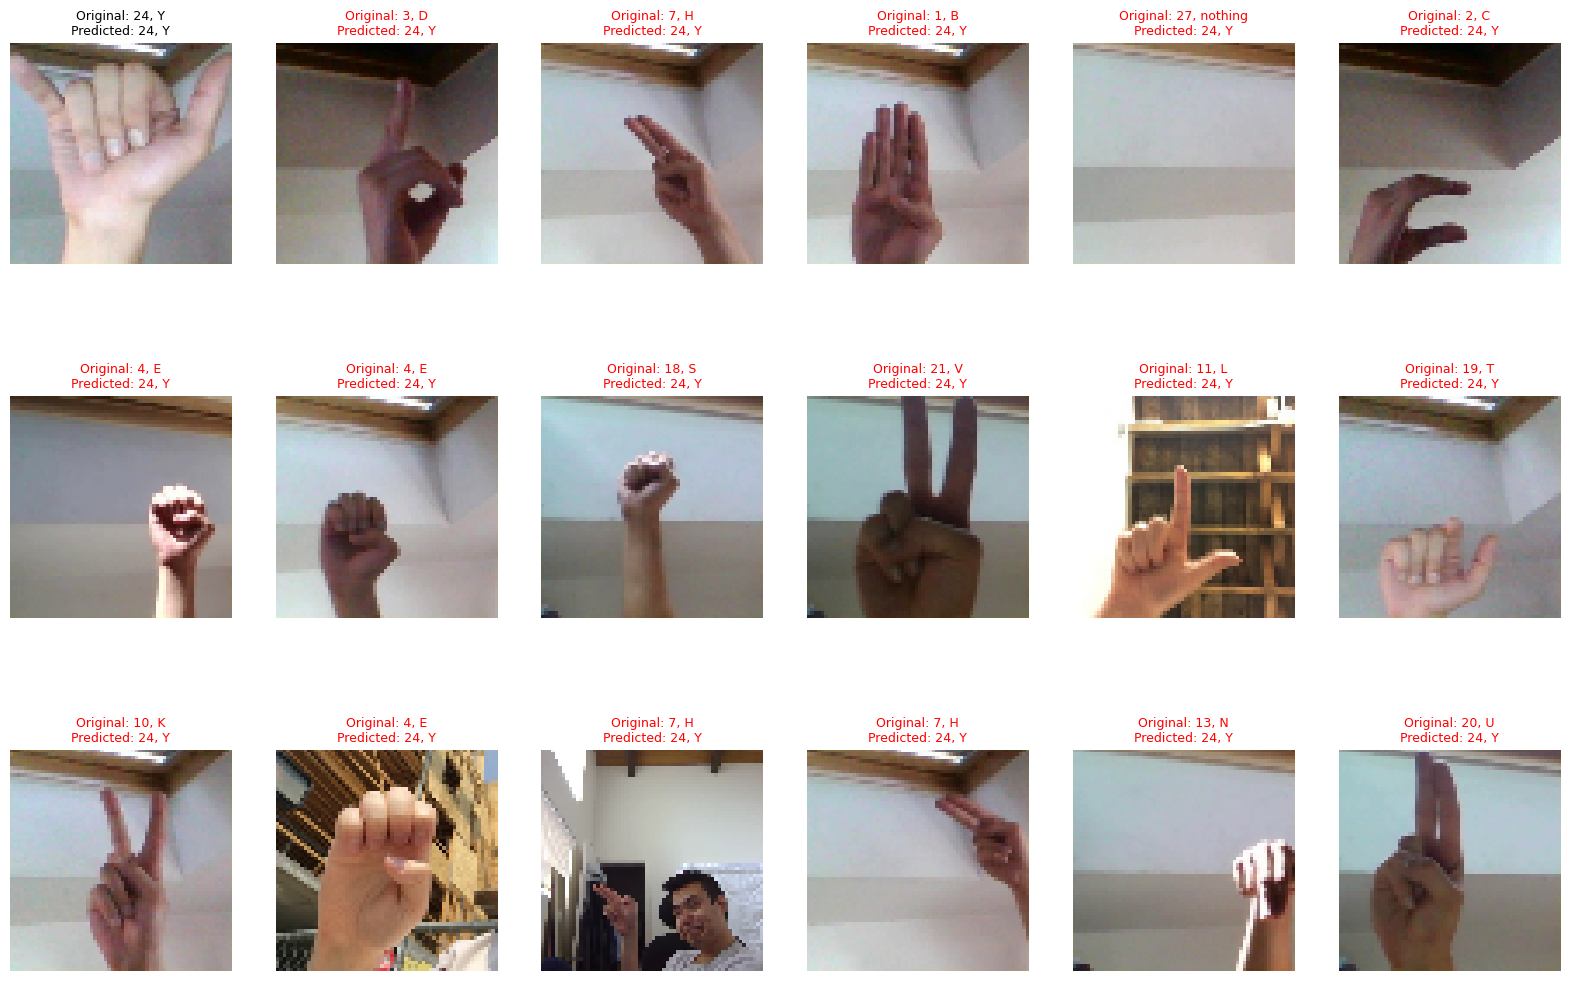

In [19]:
preview(Model().to(device), val_dataloader, 0)

In [20]:
def calculate_acc(y_pred, y):
    preds = torch.argmax(y_pred, dim=1)
    num_correct = (preds == y).sum().item()

    return num_correct / len(y)

In [21]:
def train_one_epoch(device, dataloader, model, loss_fn, optimizer):
    model.train()
    avg_loss, avg_acc = 0, 0
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        # Get prediction 
        y_pred = model(x)

        # Compute loss
        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()
        
        # Compute acc
        acc = calculate_acc(y_pred, y)
        avg_acc += acc
        
        # Update parameters
        loss.backward()
        optimizer.step()

        print(f'training step: {i+1}/{len(dataloader)}, loss: {loss.item():>5f}, acc: {acc:>5f}', end='\r')
    
    print()

    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)
        
    return (avg_loss, avg_acc)

In [22]:
def validate(device, dataloader, model, loss_fn, epoch):    
    model.eval()
    avg_loss, avg_acc = 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            
            loss = loss_fn(y_pred, y).item()
            avg_loss += loss
            
            acc = calculate_acc(y_pred, y)
            avg_acc += acc

            print(f'validation step: {i+1}/{len(dataloader)}, loss: {loss:>5f}, acc: {acc:>5f}', end='\r')

    print()
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)

    preview(model, dataloader, epoch, save=True, use_wandb=use_wandb, step=epoch)
    
    return (avg_loss, avg_acc)

In [23]:
if not os.path.isdir('outputs'):
    os.mkdir('outputs')

In [24]:
model = Model().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

if config['scheduler']:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1)

early_stopper = EarlyStopper(patience=5, delta=0, mode='min')

In [25]:
epochs = config['epochs']
train_history = {'loss': [], 'acc': []}
val_history = {'loss': [], 'acc': []}
best_checkpoint = {'epoch': 0, 'val_acc': 0, 'val_loss': np.inf, 'model_state': None, 'optimizer_state': None}

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    
    train_loss, train_acc = train_one_epoch(device, train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc = validate(device, val_dataloader, model, loss_fn, epoch)

    print('-------------------------------')
    
    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)

    val_history['loss'].append(val_loss)
    val_history['acc'].append(val_acc)

    if config['scheduler']:
        scheduler.step(val_loss)
    
    print(f'loss: {train_loss:>5f} acc: {train_acc:>5f}')
    print(f'val loss: {val_loss:>5f} val acc: {val_acc:>5f}')
    # print(f'lr: {optimizer.param_groups[0]["lr"]:>5f}')
    print('===============================')

    torch.save({
        'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()
    }, 'outputs/checkpoint.pt')

    if best_checkpoint['val_acc'] < val_acc:
        best_checkpoint['epoch'] = epoch
        best_checkpoint['val_acc'] = val_acc
        best_checkpoint['val_loss'] = val_loss
        best_checkpoint['model_state'] = model.state_dict()
        best_checkpoint['optimizer_state'] = optimizer.state_dict()
        torch.save(best_checkpoint, 'outputs/best_checkpoint.pt')

    if use_wandb:
        wandb.log({
            'epoch': epoch, 'loss': train_loss, 'accuracy': train_acc, 
            'val_loss':val_loss, 'val_accuracy': val_acc, 'lr': optimizer.param_groups[0]["lr"]
        }, step=epoch)

    if early_stopper(val_loss):
        print('Stopping early!!!')
        break

Epoch: 0
training step: 282/282, loss: 2.063463, acc: 0.347150
validation step: 71/71, loss: 1.898016, acc: 0.433628
-------------------------------
loss: 2.896837 acc: 0.148366
val loss: 2.009249 val acc: 0.356680
Epoch: 1
training step: 282/282, loss: 1.237865, acc: 0.606218
validation step: 71/71, loss: 1.040404, acc: 0.646018
-------------------------------
loss: 1.566436 acc: 0.486026
val loss: 1.025681 val acc: 0.676242
Epoch: 2
training step: 282/282, loss: 0.749457, acc: 0.746114
validation step: 71/71, loss: 0.435737, acc: 0.902655
-------------------------------
loss: 0.895423 acc: 0.700202
val loss: 0.448237 val acc: 0.864551
Epoch: 3
training step: 282/282, loss: 0.562319, acc: 0.792746
validation step: 71/71, loss: 0.229568, acc: 0.929204
-------------------------------
loss: 0.608641 acc: 0.796099
val loss: 0.260516 val acc: 0.928690
Epoch: 4
training step: 282/282, loss: 0.415303, acc: 0.865285
validation step: 71/71, loss: 0.124087, acc: 0.982301
-----------------------

In [26]:
torch.save(model.state_dict(), 'outputs/model.pt')
if use_wandb:
    model_artifact = wandb.Artifact('final_model', type='model')
    model_artifact.add_file('outputs/model.pt')
    wandb.log_artifact(model_artifact)

    best_checkpoint_artifact = wandb.Artifact('best_checkpoint', type='checkpoint')
    best_checkpoint_artifact.add_file('outputs/best_checkpoint.pt')
    wandb.log_artifact(best_checkpoint_artifact)
    wandb.finish()

accuracy,▁▄▆▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇████████████████
val_loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.97098
epoch,19
loss,0.09032
lr,0.01
val_accuracy,0.99147


In [27]:
fig = px.line({'loss': train_history['loss'], 'val_loss': val_history['loss']})
fig.show()

In [28]:
fig = px.line({'acc': train_history['acc'], 'val_acc': val_history['acc']})
fig.show()

## Evaluation

In [29]:
def preprocess_img(img):
    image = torch.tensor(img).float().permute(2,0,1)
    image = image / 255.0

    transform = transforms.Compose([transforms.Resize((64+4, 64+4), antialias=False), transforms.CenterCrop((64, 64))])
    image = transform(image)

    return image.unsqueeze(0)

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
data_test_dir = 'data/asl_dataset_test/'
data_test = glob.glob('*/*.jpg', root_dir=data_test_dir)
np.random.shuffle(data_test)
print(len(data_test))
print(data_test[:5])

10469
['Q/Q1903.jpg', 'A/A0027_test.jpg', 'S/S2778.jpg', 'O/O572.jpg', 'P/P919.jpg']


In [32]:
test_data = SignDataset(data_test, data_test_dir, reversed_labels_map, transform=transform, augment=False)
test_dataloader = DataLoader(test_data, batch_size=18, shuffle=False)

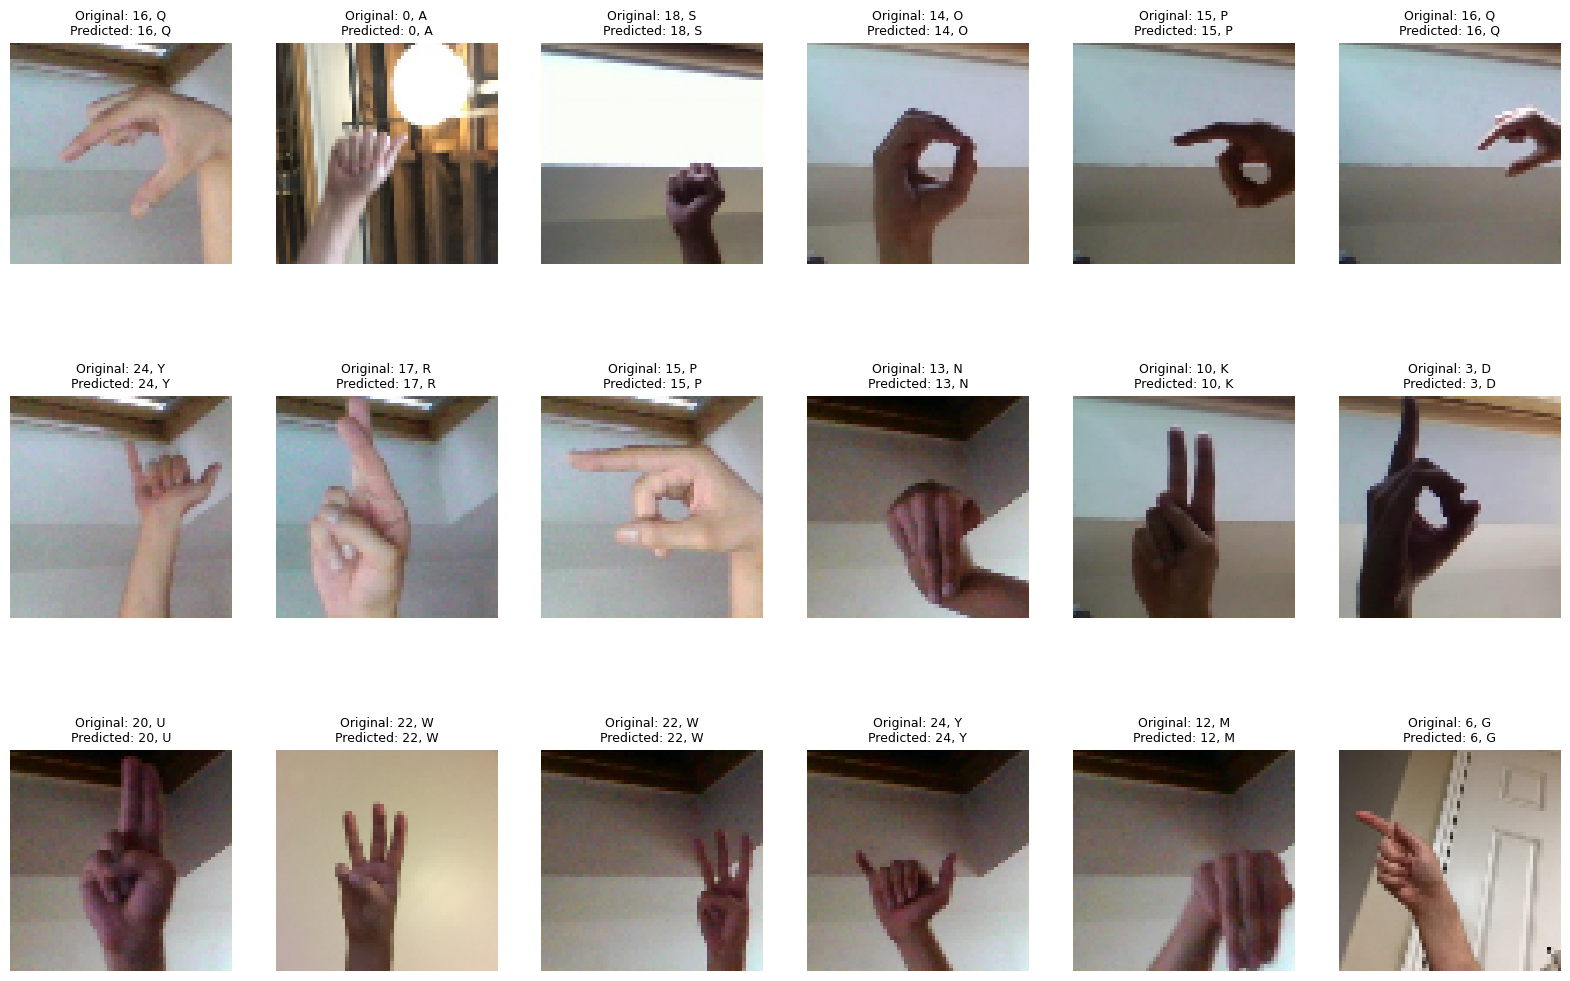

In [33]:
preview(model, test_dataloader, 'test', save=False)

In [61]:
# checkpoint = torch.load('outputs/best_checkpoint.pt')
model = Model(double=True)
checkpoint = torch.load('models/doubled_old_best.pt')
model.load_state_dict(checkpoint['model_state'])
model.eval()

Model(
  (features): Sequential(
    (block0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (block1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (block3): Sequential(

In [62]:
x, y = test_data[8]
x = x.unsqueeze(0)

In [63]:
print(y)

15


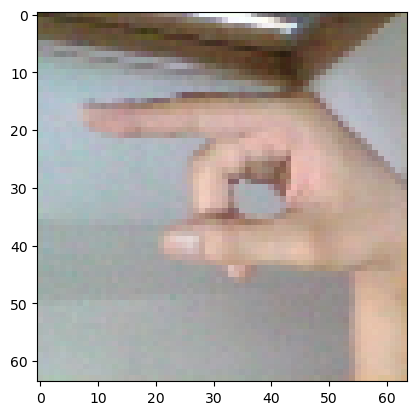

In [64]:
plt.imshow(x[0].permute(1, 2, 0).numpy())

In [65]:
probs = model(x.to(device))
print(probs)
probs = F.softmax(probs, dim=1)
print(probs)
y_pred = torch.argmax(probs, dim=1)
print(y_pred, probs[0][y_pred.item()])

RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [66]:
img = cv2.imread('data/B.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = preprocess_img(img)
img = img.cpu()

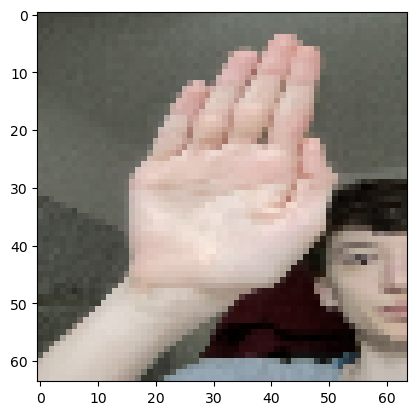

In [67]:
plt.imshow(img[0].permute(1,2,0).cpu().numpy())

In [68]:
probs = model(img)
print(probs)
probs = F.softmax(probs, dim=1)
print(probs)
y_pred = torch.argmax(probs, dim=1)
print(y_pred, probs[0][y_pred.item()])

tensor([[ -0.8162,   0.8404,   3.4368,   2.0690,  -0.8683, -10.1852,   0.8342,
           1.6224,  -3.9530,  -4.9509,  -4.9177,  -6.7744,  -2.5205,  -3.7886,
          -6.3050,  -1.6233,   0.7520,  -4.4594,  -5.3840,  -5.0539,  -1.5943,
          -6.1846,  -7.9983,  -2.6255,  -7.9952,   4.1649,   1.5005,   4.7955,
          -7.0029]], grad_fn=<AddmmBackward0>)
tensor([[1.8257e-03, 9.5693e-03, 1.2838e-01, 3.2694e-02, 1.7330e-03, 1.5579e-07,
         9.5101e-03, 2.0917e-02, 7.9273e-05, 2.9226e-05, 3.0213e-05, 4.7187e-06,
         3.3208e-04, 9.3437e-05, 7.5457e-06, 8.1459e-04, 8.7598e-03, 4.7778e-05,
         1.8952e-05, 2.6365e-05, 8.3850e-04, 8.5111e-06, 1.3877e-06, 2.9898e-04,
         1.3920e-06, 2.6590e-01, 1.8517e-02, 4.9956e-01, 3.7548e-06]],
       grad_fn=<SoftmaxBackward0>)
tensor([27]) tensor(0.4996, grad_fn=<SelectBackward0>)


### Confusion Matrix

In [69]:
def test(device, dataloader, model, loss_fn):    
    model.eval()
    avg_loss, avg_acc = 0, 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            
            preds = torch.argmax(y_pred, dim=1)
            true_labels.extend(y.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
            
            loss = loss_fn(y_pred, y).item()
            avg_loss += loss
            
            acc = calculate_acc(y_pred, y)
            avg_acc += acc
            print(f'test step: {i+1}/{len(dataloader)}, loss: {loss:>5f}, acc: {acc:>5f}', end='\r')

    print()
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)

    preview(model, dataloader, 'test', save=True)
    
    return (avg_loss, avg_acc, true_labels, predicted_labels)

In [70]:
test_loss, test_acc, true_labels, predicted_labels = test(device, test_dataloader, model.to(device), loss_fn)
print('test loss: ', test_loss)
print('test_acc: ', test_acc)

test step: 582/582, loss: 0.006590, acc: 1.000000
test loss:  0.29164741178101394
test_acc:  0.9438717067583107


In [72]:
classes = list(labels_map.values())

In [73]:
cm = confusion_matrix(true_labels, predicted_labels)
# class_counts = cm.sum(axis=1, keepdims=True)
# cm = cm / class_counts

In [74]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Heatmap(z=cm, x=classes, y=classes, text=cm, texttemplate='<b>%{text}</b>', textfont={'size': 7}, ygap=1, xgap=1))
# fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
# fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14, width=800, height=800)
fig.show()

### Interpretability

In [102]:
model.eval()
model = model.cpu()

In [103]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap

In [174]:
x, y = test_data[10]
x = x.unsqueeze(0)
x = x.cpu()

In [175]:
y_pred = model(x)
y_pred

tensor([[ 23.5586,  -5.1361,  -5.2084, -18.5802,  -1.0071, -10.0167, -16.6454,
         -28.5928, -11.9781,  -8.0384, -15.4296,  -9.9092,   1.2679,  -6.6857,
          -6.9926, -23.9563, -11.1825,  -7.2162,   6.3561,   1.1569, -12.5844,
         -16.8116,  -9.8646,   3.2475,  -3.6183,   0.7096, -20.3245,  -0.7498,
         -15.6318]], grad_fn=<AddmmBackward0>)

In [176]:
y_pred = torch.argmax(y_pred, dim=1)
print(f'predicted: {labels_map[y_pred.item()]}, original: {labels_map[y]}')

predicted: A, original: A


### IntegratedGradients

In [177]:
integrated_gradients = IntegratedGradients(model.cpu())
attributions_ig = integrated_gradients.attribute(x.cpu(), target=y_pred.cpu(), n_steps=200)

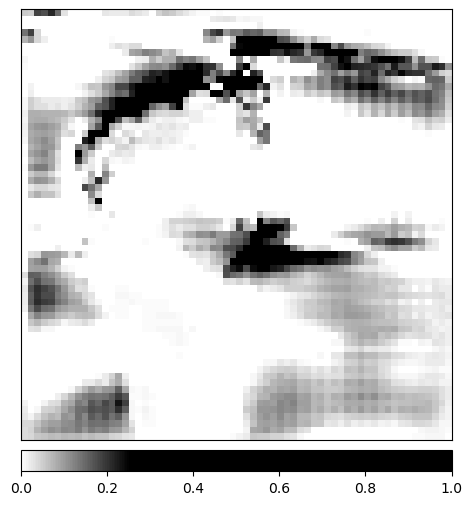

In [178]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(attributions_ig.squeeze().cpu().detach().permute(1,2,0).numpy(),
                             x.squeeze(0).cpu().detach().permute(1,2,0).numpy(),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

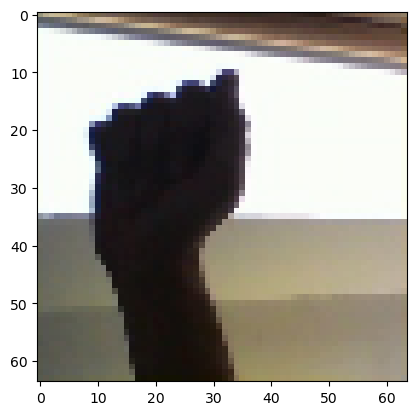

In [179]:
plt.imshow(x.squeeze(0).permute(1, 2, 0).cpu().detach())

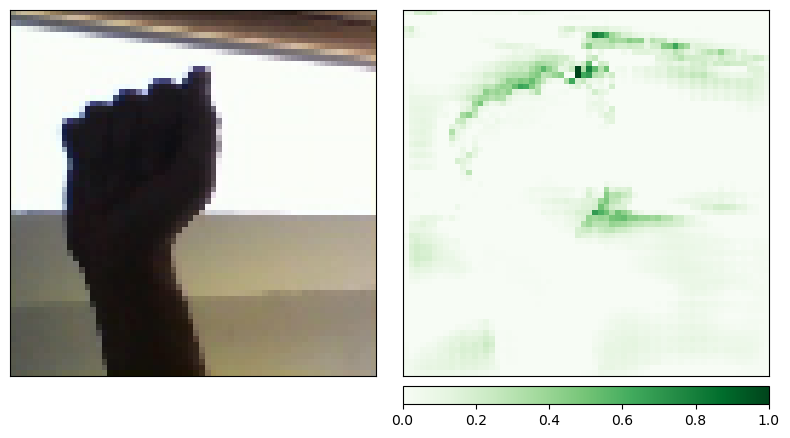

In [180]:
_ = viz.visualize_image_attr_multiple(attributions_ig.squeeze().cpu().detach().permute(1,2,0).numpy(),
                                      x.squeeze().cpu().detach().permute(1,2,0).numpy(),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=1,
                                     )

### Occlusion

In [181]:
occlusion = Occlusion(model)
attributions_occ = occlusion.attribute(x, strides = (3, 4, 4), target=y_pred, sliding_window_shapes=(3, 8, 8), baselines=0)

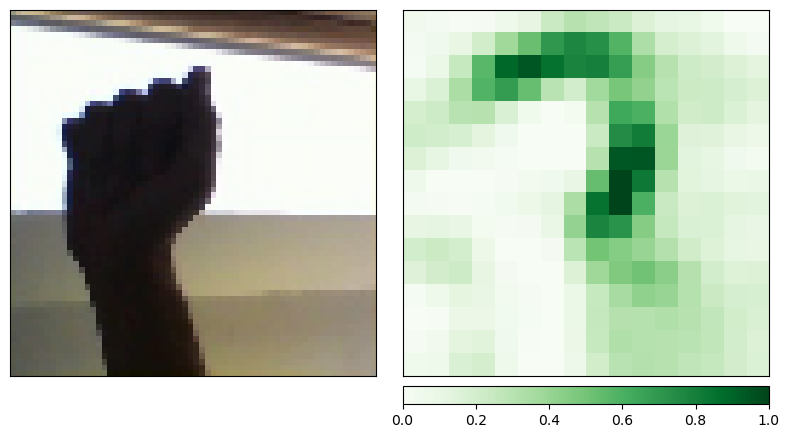

In [182]:
_ = viz.visualize_image_attr_multiple(attributions_occ.squeeze().cpu().detach().permute(1,2,0).numpy(),
                                      x.squeeze().cpu().detach().permute(1,2,0).numpy(),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [183]:
occlusion = Occlusion(model)
attributions_occ = occlusion.attribute(x, strides = (1, 4, 4), target=y_pred, sliding_window_shapes=(1, 4, 4), baselines=0)

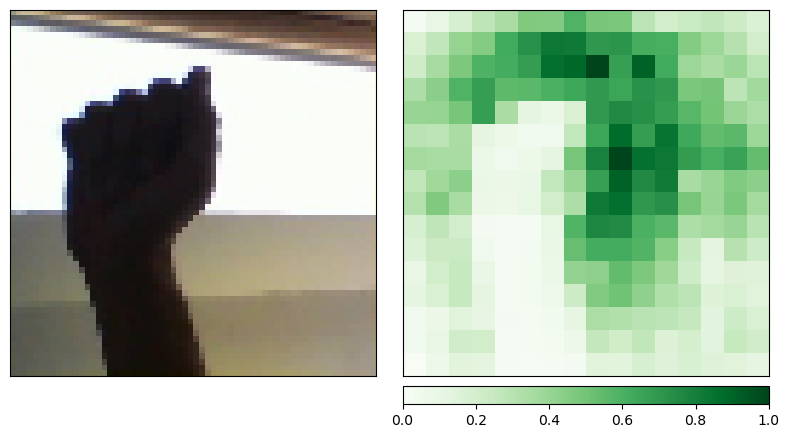

In [184]:
_ = viz.visualize_image_attr_multiple(attributions_occ.squeeze().cpu().detach().permute(1,2,0).numpy(),
                                      x.squeeze().cpu().detach().permute(1,2,0).numpy(),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

### Grad CAM

In [75]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [76]:
cam = GradCAM(model=model, target_layers=[model.features[-1][-1]])

In [77]:
x, y = test_data[11]
img = x.unsqueeze(0)

In [112]:
img = cv2.imread('data/V.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = preprocess_img(img)
img = img.to(device)

In [113]:
model.cpu()

Model(
  (features): Sequential(
    (block0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (block1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (block3): Sequential(

In [114]:
c = cam(img.cpu())[0,:]
c.shape

(64, 64)

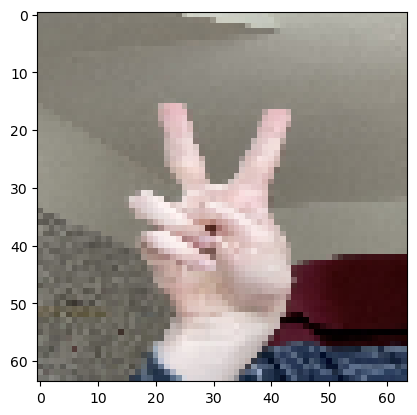

In [115]:
img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
plt.imshow(img)

In [116]:
cam_image = show_cam_on_image(img, c, use_rgb=True)
cam_image.shape

(64, 64, 3)

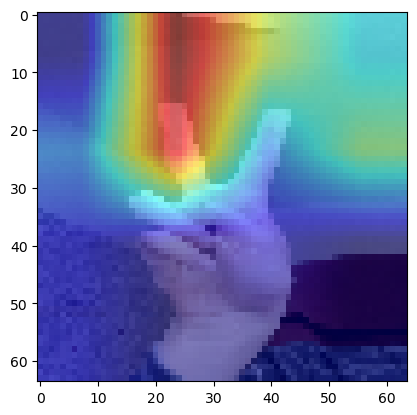

In [117]:
plt.imshow(cam_image)

(-0.5, 63.5, 63.5, -0.5)

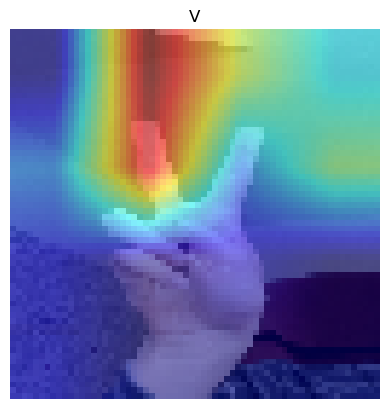

In [119]:
fig, axs = plt.subplots(1, 1)
axs.imshow(cam_image)
axs.set_title('V')
axs.axis('off')